In [1]:
import os
import tifffile as tiff
from PIL import Image
import matplotlib.pyplot as plt

from datasets import Cell_Challenge_MaskRCNN_Dataset
from training import train_MaskRCNN, EarlyStopping
from segmentation import post_processing
from visualization import plot_mini_batch

import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

import albumentations as alb

In [2]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='MaskRCNN_ResNet50_FPN_Weights.DEFAULT')
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features , 2)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask , hidden_layer , 2)

In [3]:
from labeling import readJson

jsons = os.listdir("content/Segmentation/training_data/Fluo-N3DH-CHO/01_LB")

mascaras = []
for json in jsons:
    mascaras.append(np.array(readJson(os.path.join("content/Segmentation/training_data/Fluo-N3DH-CHO/01_LB", json))))

In [3]:
from torch.utils.data import Dataset
from torchvision import transforms

In [24]:
class Cell_Challenge_MaskRCNN_Dataset(Dataset):
    """
    Creates a Dataset out of all possible in http://celltrackingchallenge.net/ and prepares
    it to use it with Mask RCNN pretrained model from PyTorch.

    Inputs:
        - cell_type: cell type of dataset to create
        - transforms: transformation for data augmentation, preferably created with Albumentations
                      so that it can take as inputs both images and masks.
        - test: boolean indicating wether its training or testing. If false, both images and masks
                will be taken in place.
        - binary: boolean indicating wether perform semantic segmentation (if True) or instance.

    Outputs: a list containing [images, target] where the images are tensors with 3 channels (all of
             them are the same, but it is necessary for this NN) and targets contains:
             - boxes: coordinates for box detection of the instances
             - labels: vector of int values for different instances only if binary = False. If not,
                       the tensor will be of ones of length the number of instances.
             - masks: tensor of [number_instances, H, W] containing the mask for each of the instances.
                      If binary=True, number_instances=1 having a global mask.

    Remarks: Cell Challenge Datasets are divided in two folders (time 01 and 02) corresponding to
             different measures. This function merges both folders to create a unique dataset instead
             of creating two different ones and training the UNet in different steps.
    """

    def __init__(self, cell_type, transforms=None, test=False, binary=True):

        self.cell_type = cell_type

        if not test:
            self.image_path1 = f'content/Segmentation/training_data/{self.cell_type}/01'
            self.image_path2 = f'content/Segmentation/training_data/{self.cell_type}/02'
            self.mask_path1 = f'content/Segmentation/training_data/{self.cell_type}/01_ST/SEG'
            self.mask_path2 = f'content/Segmentation/training_data/{self.cell_type}/02_ST/SEG'
            self.names1 = sorted(os.listdir(self.mask_path1))
            self.names2 = sorted(os.listdir(self.mask_path2))

        else:
            self.image_path1 = f'content/Segmentation/training_data/{self.cell_type}/01'
            self.image_path2 = f'content/Segmentation/training_data/{self.cell_type}/02'
            self.names1 = sorted(os.listdir(self.image_path1))
            self.names2 = sorted(os.listdir(self.image_path2))

        self.binary = binary

        self.transforms = transforms

        self.test = test
        
    def __len__(self):
        
        return len(self.names1 + self.names2)
        
    def __getitem__(self, idx):

        if self.test:
            # slice = np.random.randint(0,5)  # selects a random slice in Z
            slice = 0

            if idx < len(self.names1):
                image_name = os.path.join(self.image_path1, self.names1[idx])
            
            else:
                image_name = os.path.join(self.image_path2, self.names2[idx-len(self.names1)])
                
            img = tiff.imread(image_name)[slice]  # shape (443, 512)
            img = transforms.ToTensor()(img) # shape (1, 443, 512)

            return img
        
        # Training mode
        if idx < len(self.names1):
            name = self.names1[idx].split(".")[0]  # [man_seg_idx_slice, tif]

        else:
            name = self.names2[idx-len(self.names1)].split(".")[0]
        
        # Extract image index and slice out of mask file name
        split = name.split("_")  # [man, seg, idx, slice]
        image_idx = split[1][3:]     # idx
        # image_slice = split[3]   # slice

        # Path to images and mask corresponding to the same measure
        if idx < len(self.names1):
            image_name = os.path.join(self.image_path1, f't{image_idx}.tif')
            mask_name = os.path.join(self.mask_path1, self.names1[idx])
        
        else:
            image_name = os.path.join(self.image_path2, f't{image_idx}.tif')
            mask_name = os.path.join(self.mask_path2, self.names2[idx-len(self.names1)])

        img = tiff.imread(image_name)[0]   # shape (443, 512)
        mask = tiff.imread(mask_name)[0].astype(np.float32)  # shape (443, 512)

        obj_ids = np.unique(mask)  # instances in the mask 
        obj_ids = obj_ids[1:]      # background doesn't count
        num_objs = len(obj_ids)    # total number of instances

        # Only semantic (not instance) segmentation
        if self.binary:
            mask = mask > 0

        if self.transforms is not None:
            num_objs = 0

            # Perform data augmentation assuring that there is a cell in the image
            while num_objs < 1:
                augmented = self.transforms(image=img, mask=mask)

                # Retrieve the augmented image and mask
                img_augmented = augmented['image']
                mask_augmented = augmented['mask']

                # Check if there are instances in the augmentations
                obj_ids = np.unique(mask_augmented)
                obj_ids = obj_ids[1:]
                num_objs = len(obj_ids)
        
            # H and W correspond to the Crop made. If not, (443,512)
            img = img_augmented    # shape (H, W)
            mask = mask_augmented  # shape (H, W)

        # Tensor with mask for each of the instances
        masks = np.zeros((num_objs , mask.shape[0] , mask.shape[1]))
        boxes = []
        for i,obj in enumerate(obj_ids):
            masks[i][mask == obj] = True

            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin , ymin , xmax , ymax])
            
        boxes = torch.as_tensor(boxes , dtype = torch.float32)
        labels = torch.ones((num_objs,) , dtype = torch.int64)
        
        img = Image.fromarray(img).convert("RGB")         # shape (3, W, H)
        img = transforms.ToTensor()(img)                  # shape (3, H, W)
        mask = torch.as_tensor(masks, dtype=torch.uint8)  # shape (1, H, W)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = mask

        return img, target

In [25]:
cell_type = "Fluo-N3DH-CHO"
batch_size = 4

tranfor = alb.Compose([
    # alb.RandomCrop(width=300, height=300),
    alb.HorizontalFlip(p=0.5),
    alb.VerticalFlip(p=0.5),
    # alb.RandomBrightnessContrast(p=0.5)
    # Add more transformations as needed
], additional_targets={'image': 'image', 'mask': 'image'})

Train1 = Cell_Challenge_MaskRCNN_Dataset(cell_type, tranfor, test=False)
# Train2 = Cell_Challenge_MaskRCNN_Dataset(cell_type, '02', tranfor, binary=True)

Cell_train1, Cell_val1 = random_split(Train1, [0.8, 0.2])
# Cell_train2, Cell_val2 = random_split(Train2, [0.7, 0.3])

def custom(batch):
    imgs = [item[0] for item in batch]
    targ = [item[1] for item in batch]

    return [imgs, targ]

train_loader1 = DataLoader(Cell_train1, batch_size, shuffle=True, collate_fn=custom)
val_loader1 = DataLoader(Cell_val1, batch_size, shuffle=True, collate_fn=custom)

# train_loader2 = DataLoader(Cell_train2, batch_size, shuffle=True, collate_fn=custom)
# val_loader2 = DataLoader(Cell_val2, batch_size, shuffle=True, collate_fn=custom)

Test = Cell_Challenge_MaskRCNN_Dataset(cell_type, None, test=True)
test_loader = DataLoader(Test, batch_size, shuffle=False)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [27]:
model = model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
early_stopping = EarlyStopping()

In [28]:
train_loss, val_loss = train_MaskRCNN(model, device, optimizer, train_loader1, val_loader1, early_stopping, None, 100)

Epoch: 1/100, Train loss: 0.5508, Val loss: 0.2893, Val acc: 0.4574, Dice: 0.6276, IoU: 0.4574
Epoch: 2/100, Train loss: 0.2715, Val loss: 0.2626, Val acc: 0.4596, Dice: 0.6298, IoU: 0.4596
Epoch: 3/100, Train loss: 0.2489, Val loss: 0.2411, Val acc: 0.4574, Dice: 0.6277, IoU: 0.4574
Epoch: 4/100, Train loss: 0.2193, Val loss: 0.2227, Val acc: 0.4667, Dice: 0.6323, IoU: 0.4623
Epoch: 5/100, Train loss: 0.1970, Val loss: 0.1961, Val acc: 0.4670, Dice: 0.6314, IoU: 0.4613
Epoch: 6/100, Train loss: 0.1804, Val loss: 0.1725, Val acc: 0.5064, Dice: 0.645, IoU: 0.476
Epoch: 7/100, Train loss: 0.1707, Val loss: 0.1655, Val acc: 0.4799, Dice: 0.6412, IoU: 0.4719
Epoch: 8/100, Train loss: 0.1610, Val loss: 0.1757, Val acc: 0.5055, Dice: 0.6409, IoU: 0.4716
Epoch: 9/100, Train loss: 0.1589, Val loss: 0.1683, Val acc: 0.5224, Dice: 0.6477, IoU: 0.4789
Epoch: 10/100, Train loss: 0.1616, Val loss: 0.1553, Val acc: 0.5209, Dice: 0.6545, IoU: 0.4864
Epoch: 11/100, Train loss: 0.1506, Val loss: 0.1529

In [29]:
torch.save(model.state_dict(), f'{os.getcwd()}/maskrcnn_model.pth') 

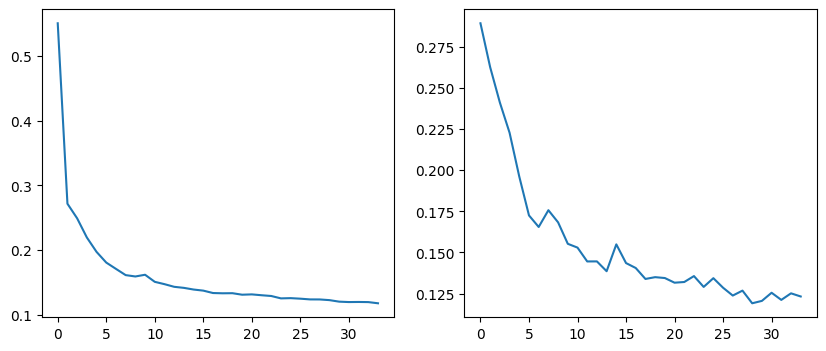

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(train_loss)
ax2.plot(val_loss)

In [22]:
# torch.save(model.state_dict(), f'{os.getcwd()}/maskrcnn_model.pth')
# model_trained = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='MaskRCNN_ResNet50_FPN_Weights.DEFAULT')
# in_features = model_trained.roi_heads.box_predictor.cls_score.in_features
# model_trained.roi_heads.box_predictor = FastRCNNPredictor(in_features , 2)
# in_features_mask = model_trained.roi_heads.mask_predictor.conv5_mask.in_channels
# hidden_layer = 256
# model_trained.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask , hidden_layer , 2)
# model_trained.load_state_dict(torch.load(f'{os.getcwd()}/maskrcnn_model.pth'))

# model = model_trained.to(device)
# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# train_loss, val_loss = train_MaskRCNN(model, device, optimizer, train_loader2, val_loader2, early_stopping, None, 20)

<All keys matched successfully>

In [4]:
# torch.save(model.state_dict(), f'{os.getcwd()}/maskrcnn_model.pth')
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='MaskRCNN_ResNet50_FPN_Weights.DEFAULT')
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features , 2)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask , hidden_layer , 2)
model.load_state_dict(torch.load(f'{os.getcwd()}/maskrcnn_model.pth'))

model = model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [31]:
imgs_test = next(iter(test_loader))
imgs_test = [img.to(device) for img in imgs_test]
model = model.to(device)
model.eval()
with torch.no_grad():
    pred = model(imgs_test)

pred_mask = [torch.sum(item['masks'], dim=(0,1)) for item in pred]
total_pred_mask = sum(pred_mask) > 0 # shape (443, 512)

imgs_test = [img.cpu() for img in imgs_test]

imgs = torch.zeros(batch_size, 443, 512)
mask = torch.zeros(batch_size, 443, 512)
for i in range(len(pred_mask)):
    imgs[i] = imgs_test[i]
    mask[i] = pred_mask[i]

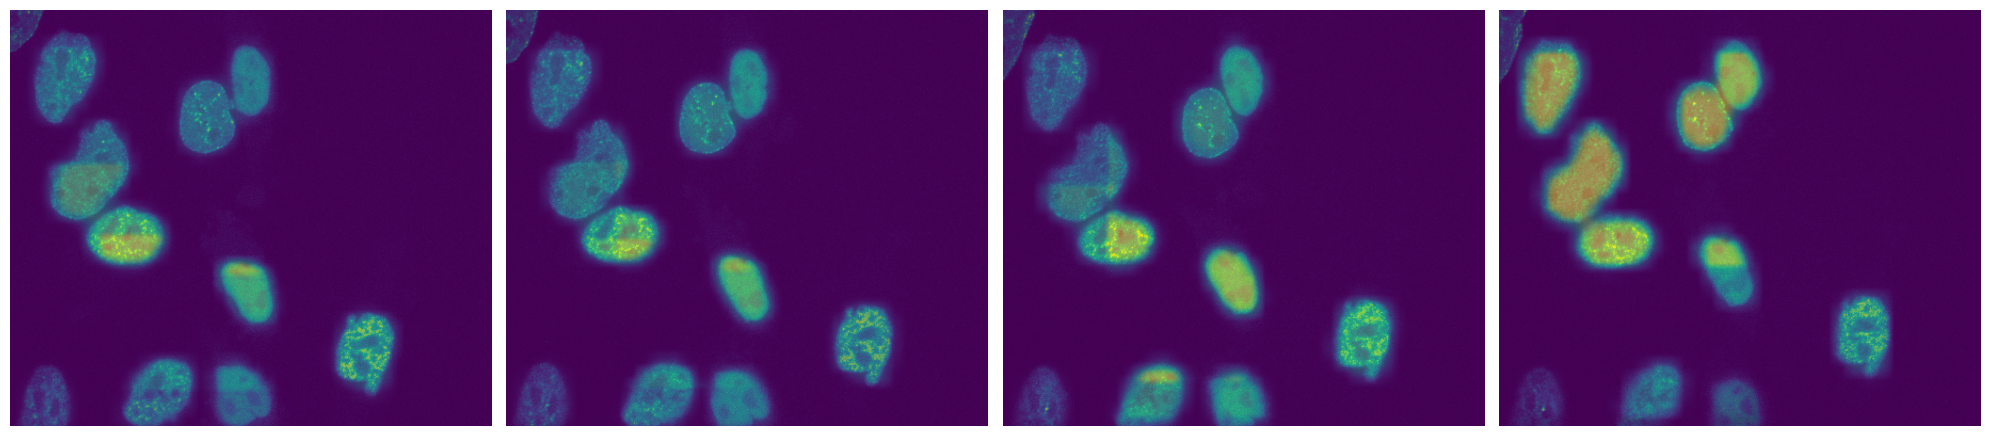

In [32]:
plot_mini_batch(imgs, mask)

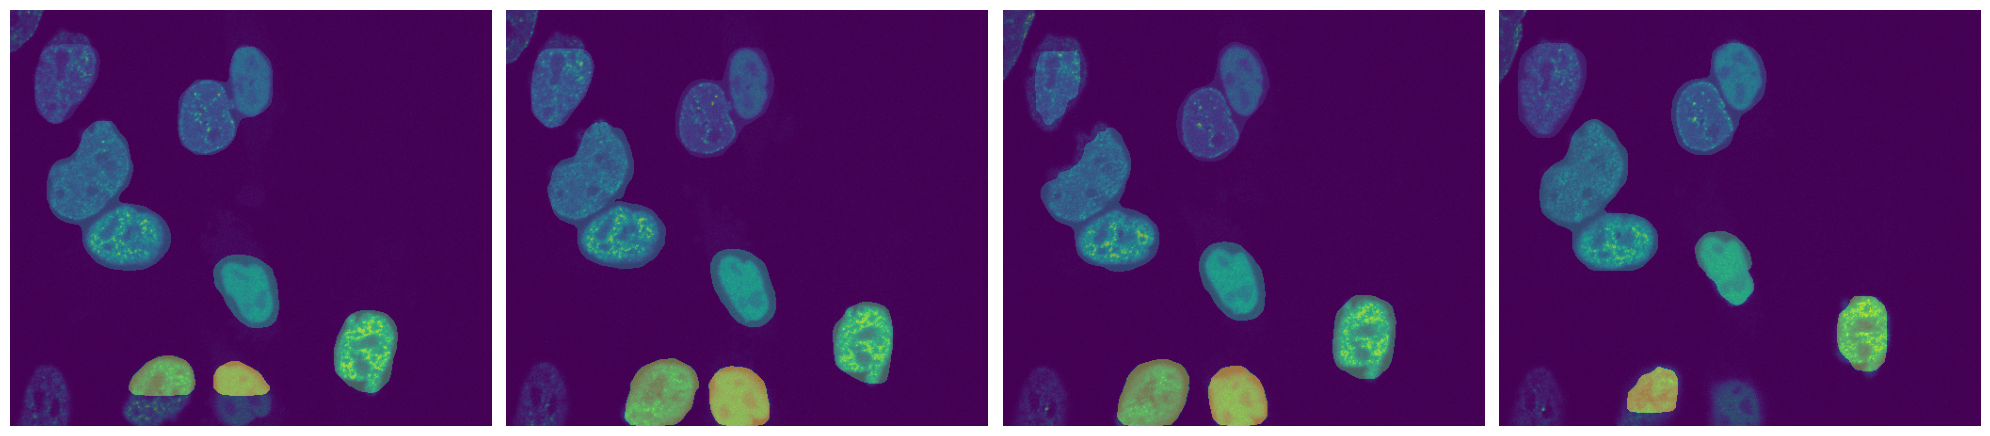

In [33]:
new_image = post_processing(mask, binary=False)
plot_mini_batch(imgs, new_image)

### Tests for Cell Tracking

In [41]:
final_pred = torch.zeros((len(Test), 443, 512))
model = model.to(device)
model.eval()
for i,imgs_test in enumerate(test_loader):
    imgs_test = [img.to(device) for img in imgs_test]

    with torch.no_grad():
        pred = model(imgs_test)

    pred_mask = [torch.sum(item['masks'], dim=(0,1)) for item in pred]
    # total_pred_mask = sum(pred_mask) > 0 # shape (443, 512)

    for j in range(len(pred_mask)):
        final_pred[i*batch_size+j,:,:] = pred_mask[j]

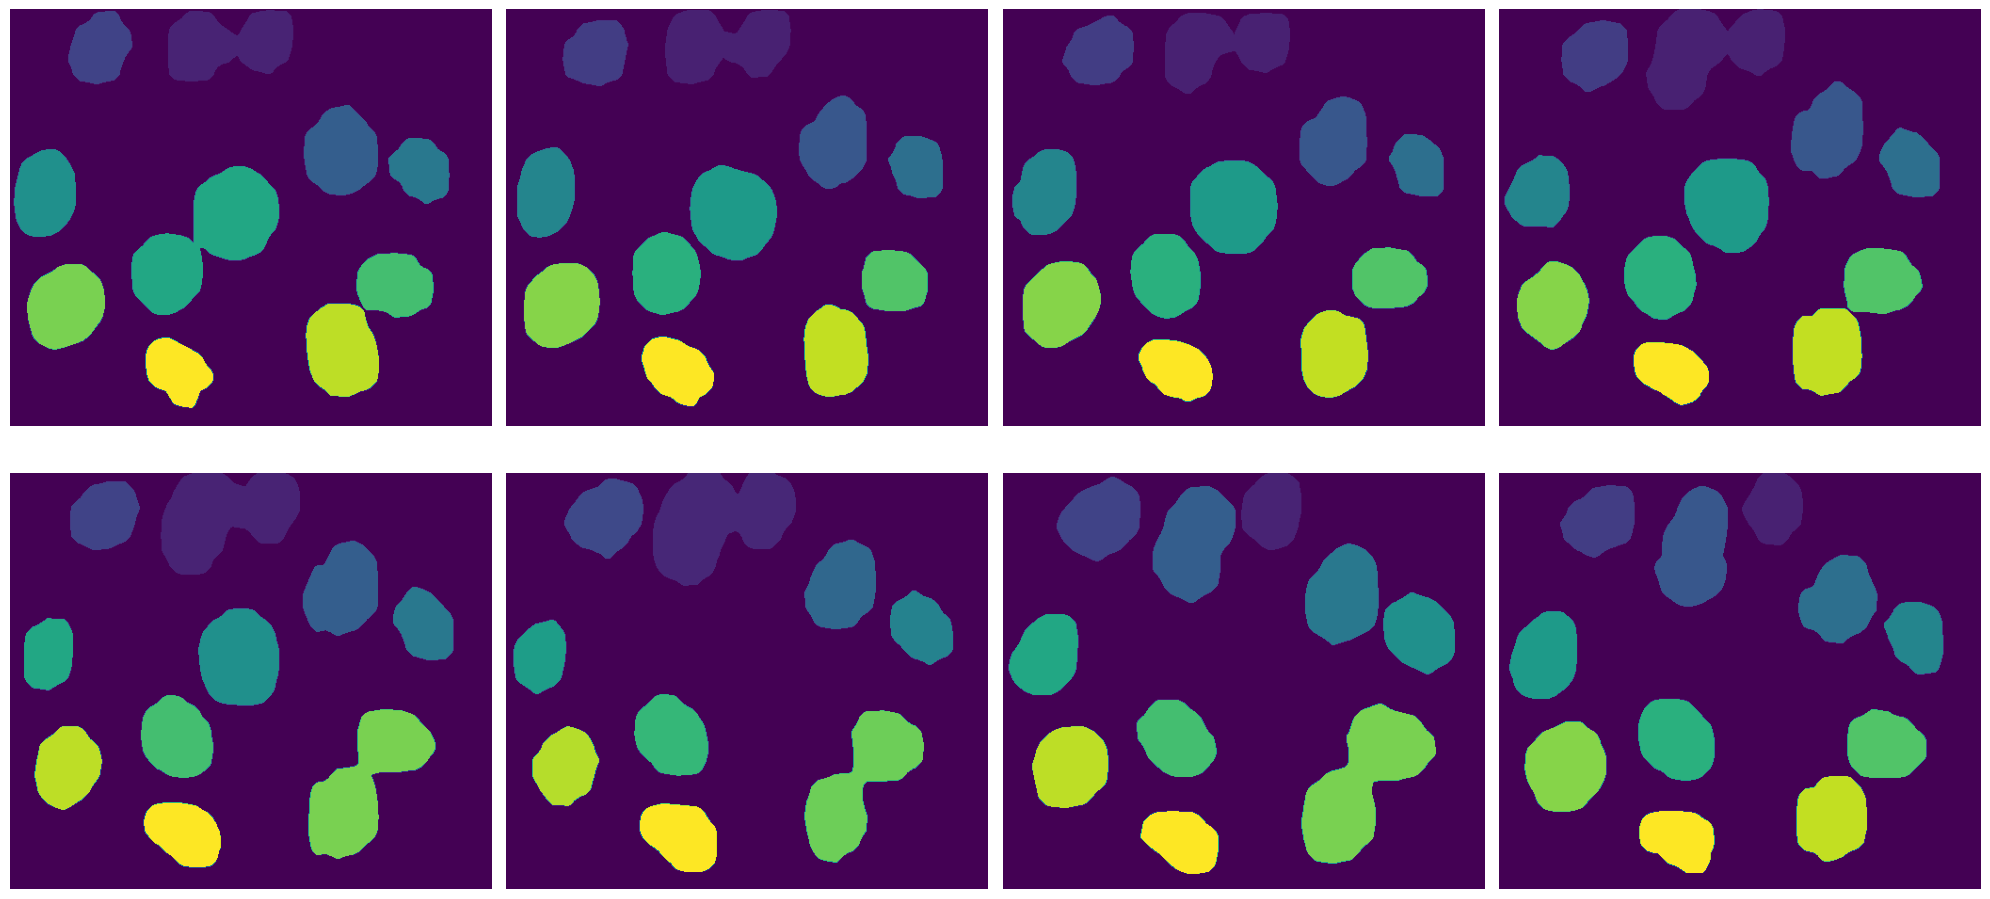

In [44]:
new_image = post_processing(final_pred[70:78], binary=False)
plot_mini_batch(new_image)

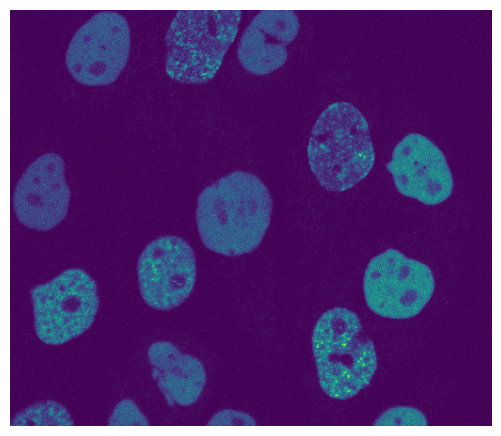

In [45]:
plot_mini_batch(Test[70])

### Tracking with Feature Extration

In [114]:
import cv2
import numpy as np

# Load the segmented cell masks for each frame
segmented_masks = new_image  # List of segmented masks for each frame

# Define a function to compute the centroid of a binary mask
def compute_centroid(mask):
    moments = cv2.moments(mask)
    centroid_x = int(moments["m10"] / moments["m00"])
    centroid_y = int(moments["m01"] / moments["m00"])
    return centroid_x, centroid_y

In [131]:
class Cell:
    def __init__(self, frame, label, centroid):
        self.frame = frame
        self.label = label
        self.centroid = centroid

In [135]:
# Perform centroid-based tracking
num_frames = len(segmented_masks)
frames = []
for frame_idx in range(num_frames):
    current_frame = segmented_masks[frame_idx]
    num_cells = int(np.max(current_frame))

    # Iterate over each cell in the current frame
    for cell_id in range(1, num_cells + 1):  # Assuming cell IDs start from 1
        # Create a binary mask for the current cell
        cell_mask = np.uint8(current_frame == cell_id)

        # Compute the centroid of the cell
        centroid = compute_centroid(cell_mask)

    # Store the centroids for the current frame
        frames.append(Cell(frame_idx, cell_id, centroid))

In [152]:
for cell in frames:
    frame = cell.__dict__["frame"]
    label = cell.__dict__["label"]
    centroid = cell.__dict__["centroid"]

    print(f"Frame {frame}: Cell {label}: Centroid = {centroid}")

Frame 0: Cell 1: Centroid = (304, 85)
Frame 0: Cell 2: Centroid = (434, 113)
Frame 0: Cell 3: Centroid = (196, 155)
Frame 0: Cell 4: Centroid = (383, 238)
Frame 0: Cell 5: Centroid = (93, 261)
Frame 0: Cell 6: Centroid = (265, 296)
Frame 0: Cell 7: Centroid = (140, 356)
Frame 0: Cell 8: Centroid = (412, 383)
Frame 0: Cell 9: Centroid = (270, 400)
Frame 1: Cell 1: Centroid = (57, 77)
Frame 1: Cell 2: Centroid = (230, 100)
Frame 1: Cell 3: Centroid = (83, 184)
Frame 1: Cell 4: Centroid = (122, 241)
Frame 1: Cell 5: Centroid = (249, 284)
Frame 2: Cell 1: Centroid = (231, 93)
Frame 2: Cell 2: Centroid = (51, 90)
Frame 2: Cell 3: Centroid = (100, 222)
Frame 2: Cell 4: Centroid = (230, 247)
Frame 2: Cell 5: Centroid = (387, 329)
Frame 2: Cell 6: Centroid = (163, 412)
Frame 2: Cell 7: Centroid = (250, 413)
Frame 3: Cell 1: Centroid = (49, 77)
Frame 3: Cell 2: Centroid = (230, 84)
Frame 3: Cell 3: Centroid = (77, 197)
Frame 3: Cell 4: Centroid = (204, 229)
Frame 3: Cell 5: Centroid = (122, 270

In [118]:
# Perform centroid-based tracking
num_frames = len(segmented_masks)
frames = []
for frame_idx in range(num_frames):
    current_frame = segmented_masks[frame_idx]
    num_cells = int(np.max(current_frame))

    # Initialize an empty list to store the centroids for the current frame
    centroids = {}

    # Iterate over each cell in the current frame
    for cell_id in range(1, num_cells + 1):  # Assuming cell IDs start from 1
        # Create a binary mask for the current cell
        cell_mask = np.uint8(current_frame == cell_id)

        # Compute the centroid of the cell
        centroid = compute_centroid(cell_mask)

        # Add the centroid to the list
        centroids[cell_id] = centroid

    # Store the centroids for the current frame
    frames.append(centroids)

# Print the tracked cell centroids for each frame
for frame_idx, frame_cells in enumerate(frames):
    print(f"Frame {frame_idx}:")
    for cell_idx, cell_centroid in frame_cells.items():
        print(f"Cell {cell_idx}: Centroid = {cell_centroid}")
    print()

Frame 0:
Cell 1: Centroid = (304, 85)
Cell 2: Centroid = (434, 113)
Cell 3: Centroid = (196, 155)
Cell 4: Centroid = (383, 238)
Cell 5: Centroid = (93, 261)
Cell 6: Centroid = (265, 296)
Cell 7: Centroid = (140, 356)
Cell 8: Centroid = (412, 383)
Cell 9: Centroid = (270, 400)

Frame 1:
Cell 1: Centroid = (57, 77)
Cell 2: Centroid = (230, 100)
Cell 3: Centroid = (83, 184)
Cell 4: Centroid = (122, 241)
Cell 5: Centroid = (249, 284)

Frame 2:
Cell 1: Centroid = (231, 93)
Cell 2: Centroid = (51, 90)
Cell 3: Centroid = (100, 222)
Cell 4: Centroid = (230, 247)
Cell 5: Centroid = (387, 329)
Cell 6: Centroid = (163, 412)
Cell 7: Centroid = (250, 413)

Frame 3:
Cell 1: Centroid = (49, 77)
Cell 2: Centroid = (230, 84)
Cell 3: Centroid = (77, 197)
Cell 4: Centroid = (204, 229)
Cell 5: Centroid = (122, 270)
Cell 6: Centroid = (389, 299)
Cell 7: Centroid = (250, 401)
Cell 8: Centroid = (162, 409)

Frame 4:
Cell 1: Centroid = (51, 81)
Cell 2: Centroid = (234, 89)
Cell 3: Centroid = (71, 216)
Cell 4:

In [119]:
# Define a threshold for centroid distance
threshold = 50

# Initialize an empty dictionary to store the cell correspondences
correspondences = {}

for current_frame_idx, current_frame in enumerate(frames[1:], start=1):

    previous_frame = frames[current_frame_idx - 1]
    for current_cell in current_frame:
        best_match = None
        best_distance = np.inf

        current_centroid = np.array(current_frame[current_cell])

        for previous_cell in previous_frame:
            previous_centroid = np.array(previous_frame[previous_cell])
            distance = np.linalg.norm(current_centroid - previous_centroid)

            # Update the best match if the distance is below the threshold
            if distance < threshold and distance < best_distance:
                best_match = previous_cell
                best_distance = distance
            
        # Store the correspondence in the dictionary
        if best_match is not None:
            correspondences[current_cell] = best_match
        
        else:
            correspondences[current_cell] = None

    # Print the correspondences
    print(f"Frame {current_frame_idx}")
    for current_cell_id, previous_cell_id in correspondences.items():
        print(f"Current Cell {current_cell_id} corresponds to Previous Cell {previous_cell_id}")

Frame 1
Current Cell 1 corresponds to Previous Cell None
Current Cell 2 corresponds to Previous Cell None
Current Cell 3 corresponds to Previous Cell None
Current Cell 4 corresponds to Previous Cell 5
Current Cell 5 corresponds to Previous Cell 6
Frame 2
Current Cell 1 corresponds to Previous Cell 2
Current Cell 2 corresponds to Previous Cell 1
Current Cell 3 corresponds to Previous Cell 4
Current Cell 4 corresponds to Previous Cell 5
Current Cell 5 corresponds to Previous Cell None
Current Cell 6 corresponds to Previous Cell None
Current Cell 7 corresponds to Previous Cell None
Frame 3
Current Cell 1 corresponds to Previous Cell 2
Current Cell 2 corresponds to Previous Cell 1
Current Cell 3 corresponds to Previous Cell 3
Current Cell 4 corresponds to Previous Cell 4
Current Cell 5 corresponds to Previous Cell None
Current Cell 6 corresponds to Previous Cell 5
Current Cell 7 corresponds to Previous Cell 7
Current Cell 8 corresponds to Previous Cell 6
Frame 4
Current Cell 1 corresponds 

In [ ]:
def update_active_cells(active_cells, frame, segmented_masks):
    new_active_cells = []
    
    # Iterate over the active cells
    for cell in active_cells:
        label = cell.label
        centroid = cell.centroid
        
        # Check if the cell is still present in the current frame
        if segmented_masks[frame][centroid[0]][centroid[1]] == label:
            # Cell is still present, add it to the new active cell list
            new_active_cells.append(Cell(label, frame, centroid))
    
    return new_active_cells

# Example code for label propagation or cell tracking

# Step 1: Initialize active cells for the first frame
frame = 0
active_cells = []

# ... Code for obtaining initial cell proposals and their features ...

# Iterate over the cell proposals
for cell_proposal in cell_proposals:
    label = cell_proposal.label
    centroid = cell_proposal.centroid
    
    # Add the cell to the list of active cells for the first frame
    active_cells.append(Cell(label, frame, centroid))

# Step 2: Propagate labels and update active cells for subsequent frames
for frame in range(1, num_frames):
    # ... Code for obtaining cell proposals and their features for the current frame ...
    
    # Step 2a: Match cell proposals with active cells from the previous frame
    # ... Code for matching cell proposals with active cells ...
    
    # Step 2b: Assign labels to cell proposals based on the matching results
    # ... Code for assigning labels to cell proposals ...
    
    # Step 2c: Update the list of active cells for the current frame
    active_cells = update_active_cells(active_cells, frame, segmented_masks)

    # ... Additional code for further processing or analysis ...


### Create video from image sequence

In [71]:
from visualization import create_video

In [99]:
# Example usage
images_folder = 'content/Segmentation/training_data/Fluo-N3DH-CHO/01'
output_path = 'content/Segmentation/training_data/Fluo-N3DH-CHO/video.mp4'
fps = 10  # Frames per second

create_video(images_folder, output_path, fps)

### Frame alignment

In [182]:
import numpy as np

def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

In [321]:
from scipy.optimize import linear_sum_assignment

def track_cells(previous_masks, current_masks):
    num_previous_cells = len(np.unique(previous_masks)) - 1
    num_current_cells = len(np.unique(current_masks)) - 1

    cost_matrix = np.zeros((num_previous_cells, num_current_cells))
    for i, id_pr in enumerate(np.unique(previous_masks)[1:]):
        for j, id_cr in enumerate(np.unique(current_masks)[1:]):
            pr_mask = previous_masks * (previous_masks==id_pr)
            cr_mask = current_masks * (current_masks==id_cr)
            cost_matrix[i, j] = 1 - calculate_iou(pr_mask, cr_mask)

    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    assignments = [(previous_cell, current_cell) for previous_cell, current_cell in zip(row_ind, col_ind)]

    return assignments

In [335]:
path = "content/Segmentation/training_data/Fluo-N3DH-CHO/01_ST/SEG"
frames = os.listdir(path)

track = np.zeros((len(frames),443,512)).astype(np.uint8)

img = tiff.imread(os.path.join(path, frames[0]))[0].astype(np.uint8)

ids_pr = np.unique(img)[1:] # [1, 4, 7, 10, ...]
copy = img.copy()
for i,id in enumerate(ids_pr, start=1):
    copy[copy==id] = i

ids_pr = np.unique(copy)[1:] # [1, 2, 3, 4, ...]
track[0] = copy

next_id = max(ids_list) + 1 # 11
for idx, frame in enumerate(frames[1:], start=1):
    img = tiff.imread(os.path.join(path, frame))[0].astype(np.uint8) # new frame

    assignments = track_cells(copy, img)

    ids_cr = np.unique(img)[1:] # new labels
    copy = img.copy() # new frame reassigned
    for pr, cr in assignments:
        copy[copy==ids_cr[cr]] = ids_pr[pr]
    
    ids_pr = np.unique(copy)[1:]

    if len(ids_cr) > len(ids_pr):
        for out_idx in ids_cr:
            if out_idx not in ids_pr:
                copy[copy==out_idx] = next_id
                next_id += 1
    
    track[idx] = copy 

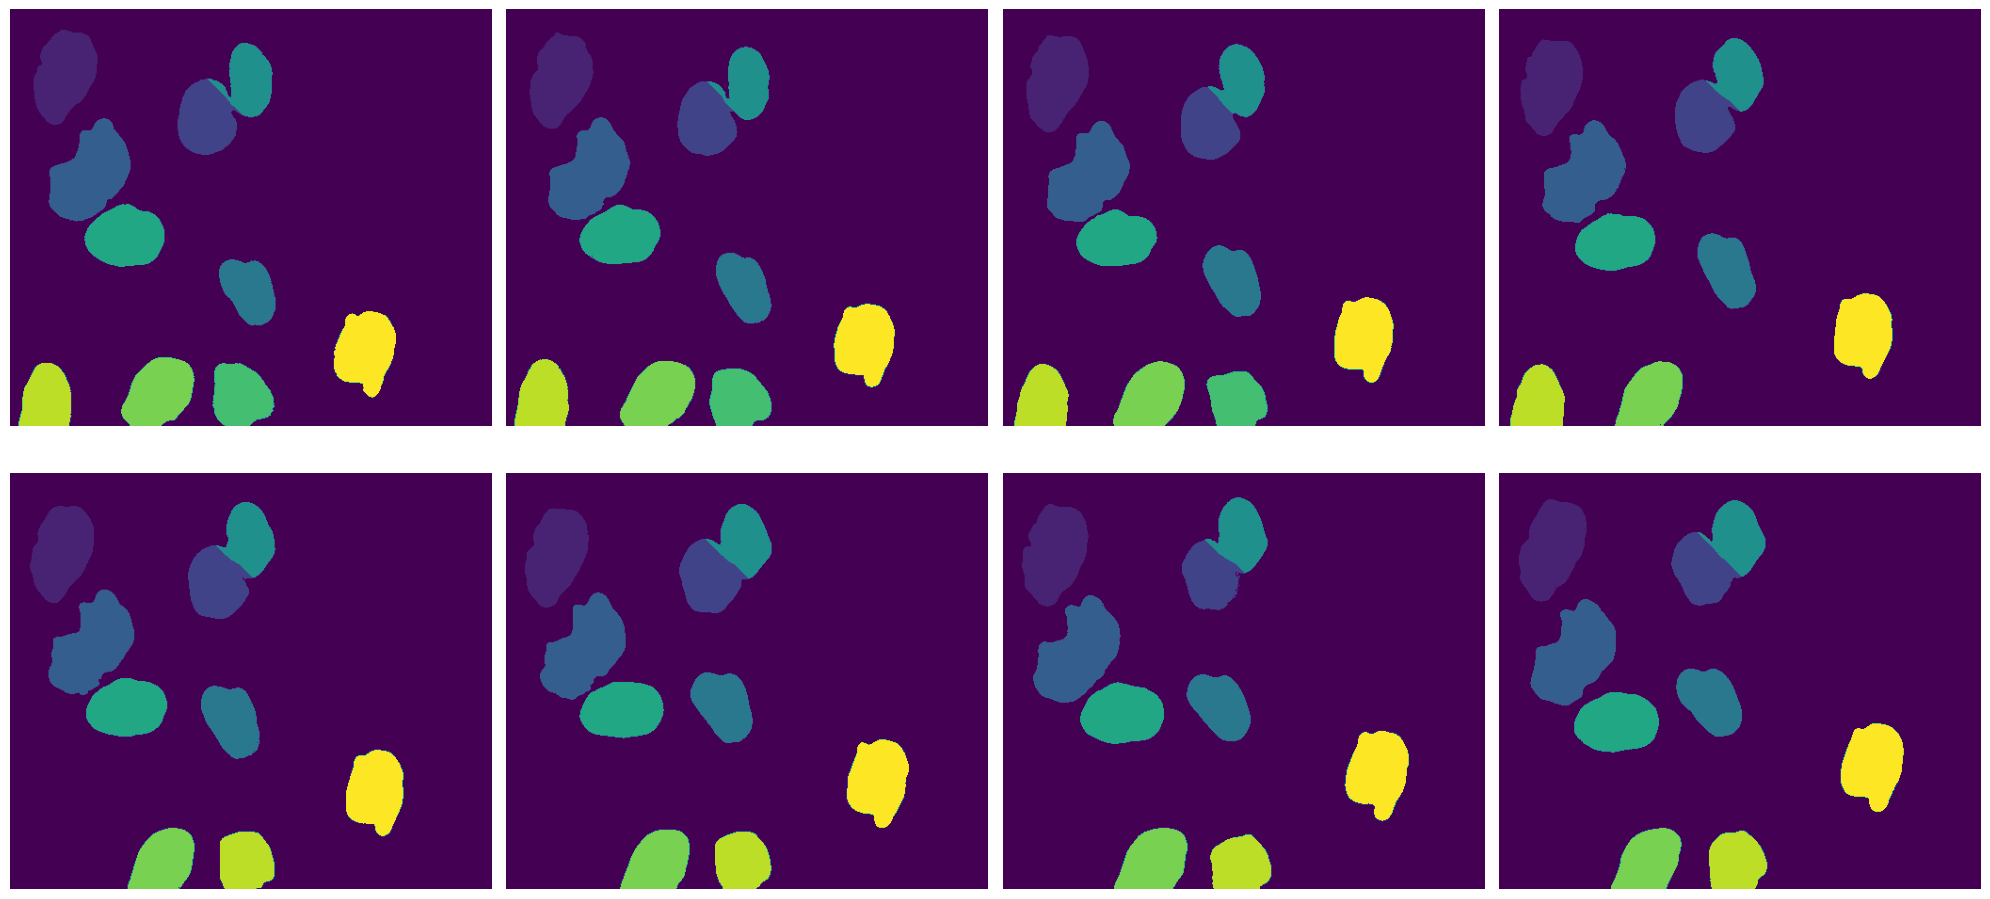

In [336]:
plot_mini_batch(track[:8])

In [353]:
np.unique(track[0])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [366]:
import cv2
import numpy as np

# Assuming you have a NumPy array called 'sequence' with shape (100, 400, 400)
sequence = track

# Define the output video filename
output_filename = 'output_video.mp4'

# Specify the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_video = cv2.VideoWriter(output_filename, fourcc, 10, (sequence.shape[2], sequence.shape[1]))

# Iterate over the frames in the sequence and write them to the video
for frame in sequence:
    # Create a color-coded representation of the frame
    frame2 = (frame*8.5).astype(np.float32)
    print(np.unique(frame2))
    frame_rgb = cv2.applyColorMap(frame, cv2.COLORMAP_JET)
    # frame_rgb = cv2.imread(frame)
    # frame_rgb = frame

    # Write the frame to the video
    output_video.write(frame_rgb)

# Release the video writer and close the video file
output_video.release()

[ 0.   8.5 17.  25.5 34.  42.5 51.  59.5 68.  76.5 85. ]
[ 0.   8.5 17.  25.5 34.  42.5 51.  59.5 68.  76.5 85. ]
[ 0.   8.5 17.  25.5 34.  42.5 51.  59.5 68.  76.5 85. ]
[ 0.   8.5 17.  25.5 34.  42.5 51.  68.  76.5 85. ]
[ 0.   8.5 17.  25.5 34.  42.5 51.  68.  76.5 85. ]
[ 0.   8.5 17.  25.5 34.  42.5 51.  68.  76.5 85. ]
[ 0.   8.5 17.  25.5 34.  42.5 51.  68.  76.5 85. ]
[ 0.   8.5 17.  25.5 34.  42.5 51.  68.  76.5 85. ]
[ 0.   8.5 17.  25.5 34.  42.5 51.  68.  76.5 85. ]
[ 0.   8.5 17.  25.5 34.  42.5 51.  68.  76.5 85. ]
[ 0.   8.5 17.  25.5 34.  42.5 51.  68.  76.5 85. ]
[ 0.   8.5 17.  25.5 34.  42.5 51.  68.  76.5 85. ]
[ 0.   8.5 17.  25.5 34.  42.5 51.  76.5 85. ]
[ 0.   8.5 17.  25.5 34.  42.5 51.  76.5 85. ]
[ 0.   8.5 17.  25.5 34.  42.5 51.  76.5 85. ]
[ 0.   8.5 17.  25.5 34.  42.5 51.  76.5 85. ]
[ 0.   8.5 17.  25.5 34.  42.5 51.  76.5 85. ]
[ 0.   8.5 17.  25.5 34.  42.5 51.  76.5 85. ]
[ 0.   8.5 17.  25.5 34.  42.5 51.  76.5 85. ]
[ 0.   8.5 17.  25.5 34.  42.5 5

In [ ]:
def update_cell_ids(assignments, current_mask):

    for previous_id, current_id in assignments:
        current_mask = current
        if previous_cell in cell_ids:
            new_cell_ids.append(cell_ids[previous_cell])
        else:
            new_cell_id = generate_new_cell_id()  # Define your method for generating new IDs
            new_cell_ids.append(new_cell_id)

    return new_cell_ids

In [ ]:
def update_cell_ids(cell_ids, assignments):
    new_cell_ids = []
    for previous_cell, current_cell in assignments:
        if previous_cell in cell_ids:
            new_cell_ids.append(cell_ids[previous_cell])
        else:
            new_cell_id = generate_new_cell_id()  # Define your method for generating new IDs
            new_cell_ids.append(new_cell_id)

    return new_cell_ids

In [ ]:
import cv2

def visualize_tracking(frame, masks, cell_ids):
    overlay = frame.copy()

    for mask, cell_id in zip(masks, cell_ids):
        contour, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(overlay, contour, -1, (0, 0, 255), 2)
        cv2.putText(overlay, str(cell_id), tuple(contour[0][0][0]), cv)